# To Do

1. Add Hungarian Molecule Matcher
2. Combine functions to make it one or two main functions to do everything

In [1]:
import os
import dill as pickle
import PDielec.UnitCell as UnitCell
import numpy as np
import pandas as pd
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.structure_matcher import StructureMatcher
from matminer.featurizers.site import CrystalNNFingerprint
from matminer.featurizers.structure import SiteStatsFingerprint
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations_with_replacement, cycle, product, permutations
import PDielec.UnitCell as UnitCell

In [2]:
class AtomicShift:
    
#   This class is used for examining direct changes in structure. It reads in a pickle file and 
#   extracts all the info which can be found in "self.readers". The starting and end structures
#   are turned into pymatgen and matminer objects. Currently, this class just contains functionality
#   to calculate indiviudial RMSD of non-H atoms and give metrics on the differences between the
#   starting and end structures.

    def __init__(self, pickle_file=None):
        """ Reads in """
        self.pickle_file = pickle_file
        self.readers = []
        self.struct_start = None
        self.struct_end = None
        self.ase_start = None
        self.ase_end = None
        self.fp_start = None
        self.fp_end = None
        self.coords_df_list = []
        self.labelled_coords_df = None
        self.rmsd_df_list = []
        self.max_rms_list = []
        self.nonH_rms_list = []
        self.alengths = []
        self.blengths = []
        self.clengths = []
        self.alphas = []
        self.betas = []
        self.gammas = []
        
    def read_pickle_file(self, pickle_file):
        # reads pickle file
        with open(pickle_file, 'rb') as f:
            self.readers = pickle.load(f)   
    
    def generate_ase(self):
        # converts self.reader structures to pymatgen_ase structure
        self.struct_start = Structure(self.readers.unit_cells[0].lattice, 
                                      self.readers.unit_cells[0].element_names, 
                                      self.readers.unit_cells[0].fractional_coordinates)
        self.atoms_start  = AseAtomsAdaptor.get_atoms(self.struct_start)
        self.struct_end = Structure(self.readers.unit_cells[-1].lattice, 
                                    self.readers.unit_cells[-1].element_names, 
                                    self.readers.unit_cells[-1].fractional_coordinates)
        self.atoms_end  = AseAtomsAdaptor.get_atoms(self.struct_end)
        
    def start_end_structure_matcher(self):
        # outputs a True/False for whether the structures are comparable and a
        # tuple of two values (min_rms, min_mapping).
        # min_rms is the minimum rms distance, 
        # min_mapping is the corresponding minimal species mapping that would map struct1 to struct2
        SM = StructureMatcher()
        struct_fit = SM.fit(self.struct_start, self.struct_end)
        rms = SM.get_rms_dist(self.struct_start, self.struct_end)
        
        return [struct_fit, rms]

    def generate_fingerprint(self):
        # converts pymatgen_ase structures to matminer_fingerprint structure
        ssf = SiteStatsFingerprint(CrystalNNFingerprint.from_preset('ops', distance_cutoffs=None),
                                   stats=('mean', 'maximum'))
        self.fp_start = np.array(ssf.featurize(self.struct_start))
        self.fp_end = np.array(ssf.featurize(self.struct_end))
        
    def start_end_comparison_metrics(self):
        # produces a list of 4 metrics which compare the fingerprint structures
        # There are a number of ways to deterine a (dis-)similarity.
        # Elucidian similarity is probably what we want
        # Cosine similarity would be useful as normalised between 0 and 1 however out structures maybe
        # too similar       
        # A small distance value indicates high similarity between two structures, whereas a large distance 
        # (>1) suggests that the structures are very dissimilar.  (0.9). Anything beyond 0.9 is most certainly
        # not the same structure prototype.    
        # The Euclidean distance is simply the square root of the squared differences between corresponding 
        # elements of the rows (or columns).
        # square root of dot product    
        # Cosine Similarity is normlised between 1, identical structure and 0 completely different
        # Modified Cosine Similarity is normlised between 1, identical structure and 0 completely different
        eu_dist = '{:.4f}'.format(np.linalg.norm(self.fp_start - self.fp_end))
        dot_prod = '{:.4f}'.format(np.dot(self.fp_start, self.fp_end) ** 0.5)
        cos_sim = '{:.4f}'.format(np.dot(self.fp_start, self.fp_end)/
                                  (np.linalg.norm(self.fp_start)*np.linalg.norm(self.fp_end)))
        mod_cos_sim = '{:.4f}'.format(np.dot(self.fp_start, self.fp_end)/
                                      np.maximum(np.linalg.norm(self.fp_start), 
                                                 np.linalg.norm(self.fp_end)) ** 2)
            
        return eu_dist, dot_prod, cos_sim, mod_cos_sim
    
    def make_dfs(self):
        # converts self.reader structures into pandas dataframes that remove 
        step = 0
        self.coords_df_list = []
        while step < len(self.readers.unit_cells):
            names_df = pd.Series(self.readers.unit_cells[step].element_names, name='Element')
            coords_df = pd.DataFrame(self.readers.unit_cells[step].xyz_coordinates)
            coords_df = coords_df.rename(columns={0:'x', 1:'y', 2:'z'})
            self.coords_df_list.append(coords_df)
            self.labelled_coords_df = coords_df
            self.labelled_coords_df = self.labelled_coords_df.rename(columns={0:'x', 1:'y', 2:'z'})
            self.labelled_coords_df["Element"] = names_df
            step += 1
    
    def calculate_individiual_RMSD(self):
        # calculates RMSD for each atom between start and end
        step = 1
        self.rmsd_df_list = []
        while step < len(self.coords_df_list):
            self.rmsd_df_list.append(self._calculate_individiual_RMSD(step))
            self.rmsd_df_list[step - 1] = self.rmsd_df_list[step - 1].rename(columns={3:'RMSD'})
            step +=1
        self.rmsd_df_list.append(self._calculate_individiual_RMSD_total())
        self.rmsd_df_list[-1] = self.rmsd_df_list[-1].rename(columns={3:'RMSD'})
#         step = 0
#         while step < (len(self.rmsd_df_list) - 1):
#             self.rmsd_df_list[step] = self.rmsd_df_list[step].rename(columns={3:'RMSD'})
#             step += 1
        
    def _calculate_individiual_RMSD(self, step):
        # helper function to calculate_individiual_RMSD()
        rms_df = self.coords_df_list[step-1] - self.coords_df_list[step]
        N = self.readers.nions
        rms_df[3] = ((((rms_df['x'] ** 2) + (rms_df['y'] ** 2) + (rms_df['z'] ** 2))/ N) ** 0.5)
        
        return rms_df
    
    def _calculate_individiual_RMSD_total(self):
        # helper function to calculate_individiual_RMSD()
        rms_df = self.coords_df_list[-1] - self.coords_df_list[0]
        N = self.readers.nions
        rms_df[3] = ((((rms_df['x'] ** 2) + (rms_df['y'] ** 2) + (rms_df['z'] ** 2))/ N) ** 0.5)
        
        return rms_df
    
    def calculate_max_rmsd_step(self):
        # extract the max rmsd for each step
        step = 0
        self.max_rms_list = []
        while step < len(self.rmsd_df_list):
            self.max_rms_list.append(self._calculate_max_rmsd_step(step))
            step += 1
            
    def _calculate_max_rmsd_step(self, step):
        # helper function for calculate_max_rmsd_step()
        return self.rmsd_df_list[step]['RMSD'].max()
    
    def plot_max_rms_step(self, cutoff=-1):
        # plots max_rms_step
        steps = list(range(1, ((len(self.readers.unit_cells)))))
        fig = plt.figure(figsize=(20, 5))
        plt.scatter(steps[:cutoff], self.max_rms_list[:cutoff])
        plt.title('Max Atomic Shift')
        plt.xlabel('Geometry Steps')
        plt.ylabel('Max Atomic Shift')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.show()
        
    def label_rms_dfs(self):
        # labels each dataframe with it's element column
        step = 0
        for step in self.rmsd_df_list:
            step['Element'] = self.labelled_coords_df['Element']
            
    def remove_H_df(self):
        # removes H rows
        step = 0
        while step < len(self.rmsd_df_list):
            self.nonH_rms_list.append(self.rmsd_df_list[step][self.rmsd_df_list[step]['Element'] != 'H'])
            step += 1
    
    def plot_nonH_RMS(self):
        # plots nonH RMS using violin plots
        sns.set(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":30, "ytick.labelsize":25})
        palette = cycle(sns.color_palette("hls", 8))
        ax = sns.violinplot(y=self.nonH_rms_list[-1]['RMSD'], x=self.nonH_rms_list[-1]['Element'])
    
    def plot_cell_dimensions(self, cutoff=-1, startfrom=0):
        # plots cell dimensions across the geometry optimisation
        steps = list(range(0, ((len(self.readers.unit_cells)))))
        for i in range(0, len(self.readers.unit_cells)): 
            unitCell = self.readers.unit_cells[i]
            a,b,c,alpha,beta,gamma = unitCell.convert_unitcell_to_abc()
            self.alengths.append(a)
            self.blengths.append(b)
            self.clengths.append(c)
        fig = plt.figure(figsize=(20, 5))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)
        ax1.scatter(steps[startfrom:cutoff], self.alengths[startfrom:cutoff])
        ax1.title.set_text('Length of a')
        ax1.set_xlabel('Geometry Steps')
        ax1.set_ylabel('Length of a \ $\mathregular{\AA}$')
        ax2.scatter(steps[startfrom:cutoff], self.blengths[startfrom:cutoff])
        ax2.title.set_text('Length of b')
        ax2.set_xlabel('Geometry Steps')
        ax2.set_ylabel('Length of b \ $\mathregular{\AA}$')
        ax3.scatter(steps[startfrom:cutoff], self.clengths[startfrom:cutoff])
        ax3.title.set_text('Length of c')
        ax3.set_xlabel('Geometry Steps')
        ax3.set_ylabel('Length of c \ $\mathregular{\AA}$')
        fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.show()  

    def plot_cell_angles(self, cutoff=-1, startfrom=0):
        # plots cell angles across the geometry optimisation
        steps = list(range(0, ((len(self.readers.unit_cells)))))
        for i in range(0, len(self.readers.unit_cells)): 
            unitCell = self.readers.unit_cells[i]
            a,b,c,alpha,beta,gamma = unitCell.convert_unitcell_to_abc()
            self.alphas.append(alpha)
            self.betas.append(beta)
            self.gammas.append(gamma)
        if np.var(self.alphas) + np.var(self.betas) + np.var(self.gammas) == 0:
            print('All Angles Fixed By Symmetry')
        else:
            fig = plt.figure(figsize=(20, 5))
            ax1 = fig.add_subplot(131)
            ax2 = fig.add_subplot(132)
            ax3 = fig.add_subplot(133)
            if np.var(self.alphas) != 0:
                ax1.scatter(steps[startfrom:cutoff], self.alphas[startfrom:cutoff])
                ax1.title.set_text('Angle of ' r'$\alpha$')
                ax1.set_xlabel('Geometry Steps')
                ax1.set_ylabel('Angle of ' r'$\alpha$' ' \ Degrees')
            else:
                print('Alpha Angle is Fixed by Symmetry')
                fig.delaxes(ax1)
            if np.var(self.betas) != 0:    
                ax2.scatter(steps[startfrom:cutoff], self.betas[startfrom:cutoff])
                ax2.title.set_text('Angle of ' r'$\beta$')
                ax2.set_xlabel('Geometry Steps')
                ax2.set_ylabel('Angle of ' r'$\beta$' ' \ Degrees')
            else:
                print('Beta Angle is Fixed by Symmetry')
                fig.delaxes(ax2)

            if np.var(self.gammas) != 0:
                ax3.scatter(steps[startfrom:cutoff], self.gammas[startfrom:cutoff])
                ax3.title.set_text('Angle of ' r'$\gamma$')
                ax3.set_xlabel('Geometry Steps')
                ax3.set_ylabel('Angle of ' r'$\gamma$' ' \ Degrees')
            else:
                print('Gamma Angle is Fixed by Symmetry')
                fig.delaxes(ax3)
        fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.show()
        
    def plot_volume_pressure(self, cutoff=-1, startfrom=0):
        # plots cell volume and cell pressure across the geometry optimisation
        fig = plt.figure(figsize=(20, 5))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        volumes = self.readers.volumes
        pressures = self.readers.pressures
        steps1 = list(range(0, ((len(volumes)))))
        steps2 = list(range(0, ((len(pressures)))))
        ax1.scatter(steps1[startfrom:cutoff], volumes[startfrom:cutoff])
        ax1.title.set_text('Volume')
        ax1.set_xlabel('Geometry Steps')
        ax1.set_ylabel('Volume')
        ax2.scatter(steps2[startfrom:cutoff], pressures[startfrom:cutoff])
        ax2.title.set_text('Pressure')
        ax2.set_xlabel('Geometry Steps')
        ax2.set_ylabel('Pressure')
        fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.show()
    
class DirectComparison:

# This class uses the same methods as above to directly compare two different final structures.
    def __init__(self, struct1_pymat=None, struct2_pymat=None, struct1_fp=None, struct2_fp=None, 
                       struct1_ase=None, struct2_ase=None):
        self.struct1_pymat = struct1_pymat
        self.struct2_pymat = struct2_pymat
        self.struct1_fp = struct1_fp
        self.struct2_fp = struct2_fp
        self.struct1_ase = struct1_ase
        self.struct2_ase = struct2_ase
        
    def start_end_structure_matcher(self):
        SM = StructureMatcher()
        struct_fit = SM.fit(self.struct1_pymat, self.struct2_pymat)
        rms = SM.get_rms_dist(self.struct1_pymat, self.struct2_pymat)
        
        return [struct_fit, rms]

    def start_end_comparison_metrics(self):
        eu_dist = '{:.4f}'.format(np.linalg.norm(self.struct1_fp - self.struct2_fp))
        dot_prod = '{:.4f}'.format(np.dot(self.struct1_fp, self.struct2_fp) ** 0.5)
        cos_sim = '{:.4f}'.format(np.dot(self.struct1_fp, self.struct2_fp)/
                                  (np.linalg.norm(self.struct1_fp)*np.linalg.norm(self.struct2_fp)))
        mod_cos_sim = '{:.4f}'.format(np.dot(self.struct1_fp, self.struct2_fp)/
                                      np.maximum(np.linalg.norm(self.struct1_fp), 
                                                 np.linalg.norm(self.struct2_fp)) ** 2)
            
        return eu_dist, dot_prod, cos_sim, mod_cos_sim

### Files

In [3]:
D2_pickle = 'C:\\Users\\Calum\\Documents\\Coding\\Python\\PDielec_Dev\\PDielec\\IVDWFiles\\D2TestFiles\\Concatenated\\D2_cat.pickle'
D3BJ_pickle = 'C:\\Users\\Calum\\Documents\\Coding\\Python\\PDielec_Dev\\PDielec\\IVDWFiles\\D3BJ\\D3BJ_cat.pickle'
D3_pickle = 'C:\\Users\\Calum\\Documents\\Coding\\Python\\PDielec_Dev\\PDielec\\IVDWFiles\\D3\\MULTIOUTCAR\\D3_cat.pickle'
NOVDW_pickle = 'C:\\Users\\Calum\\Documents\\Coding\\Python\\PDielec_Dev\\PDielec\\IVDWFiles\\NoVDW\\NoVDW_cat.pickle'
TS_pickle = 'C:\\Users\\Calum\\Documents\\Coding\\Python\\PDielec_Dev\\PDielec\\IVDWFiles\\TS\\TS_cat.pickle'
TSIHP_pickle = 'C:\\Users\\Calum\\Documents\\Coding\\Python\\PDielec_Dev\\PDielec\\IVDWFiles\\TSiHP\\TSiHP_cat.pickle'

File_List = [D2_pickle, D3_pickle, D3BJ_pickle, NOVDW_pickle, TS_pickle, TSIHP_pickle]
File_Dict = {'D2':D2_pickle, 'D3':D3_pickle,'D3BJ':D3BJ_pickle,'NOVDW':NOVDW_pickle,'TS':TS_pickle,'TSIHP':TSIHP_pickle}

### Examples

[True, (0.06892685520608857, 0.12881647713445976)]
('0.3580', '2.2078', '0.9883', '0.9390')
Alpha Angle is Fixed by Symmetry
Gamma Angle is Fixed by Symmetry


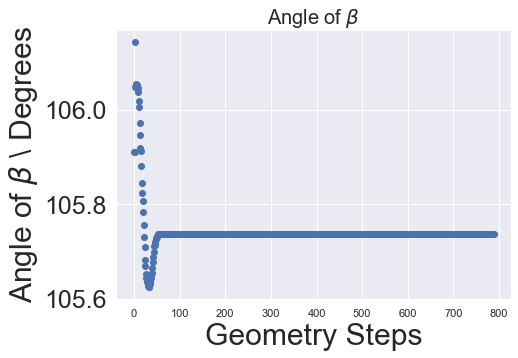

In [13]:
D2 = AtomicShift() # Call class
D2.read_pickle_file(D2_pickle)# Read pickle file
D2.generate_ase() # produces pymatgen and ase structures
D2rms = D2.start_end_structure_matcher() # provides True/False, RMS and Mapping
D2.generate_fingerprint()
D2metrics = D2.start_end_comparison_metrics() # generates comparison metrics based on fingerprint, 
                                           # needs generate_fingerprint() to happen

print(D2rms)
print(D2metrics)


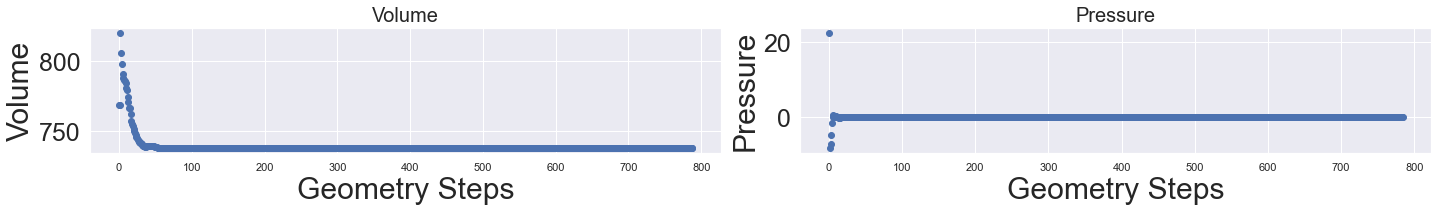

In [14]:
D2.plot_volume_pressure()

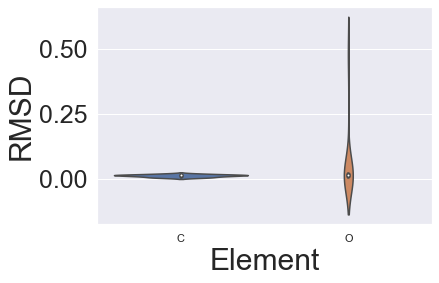

In [6]:
D2 = AtomicShift()
D2.read_pickle_file(D2_pickle)
# Order of functions to extract RMSD - will turn these into helper functions and make it one command.
D2.make_dfs()
D2.calculate_individiual_RMSD()
D2.calculate_max_rmsd_step()
D2.label_rms_dfs()
D2.remove_H_df()
D2.plot_nonH_RMS()

### Main Comparison

In [8]:
D2 = AtomicShift() # Call class
D2.read_pickle_file(D2_pickle)# Read pickle file
D2.generate_ase() # produces pymatgen and ase structures
D2.generate_fingerprint()

D3 = AtomicShift() # Call class
D3.read_pickle_file(D3_pickle)# Read pickle file
D3.generate_ase() # produces pymatgen and ase structures
D3.generate_fingerprint()

D3BJ = AtomicShift() # Call class
D3BJ.read_pickle_file(D3BJ_pickle)# Read pickle file
D3BJ.generate_ase() # produces pymatgen and ase structures
D3BJ.generate_fingerprint()

NOVDW = AtomicShift() # Call class
NOVDW.read_pickle_file(NOVDW_pickle)# Read pickle file
NOVDW.generate_ase() # produces pymatgen and ase structures
NOVDW.generate_fingerprint()

TS = AtomicShift() # Call class
TS.read_pickle_file(TS_pickle)# Read pickle file
TS.generate_ase() # produces pymatgen and ase structures
TS.generate_fingerprint()

TSiHP = AtomicShift() # Call class
TSiHP.read_pickle_file(TSIHP_pickle)# Read pickle file
TSiHP.generate_ase() # produces pymatgen and ase structures
TSiHP.generate_fingerprint()

In [9]:
File_Dict = {'D2':D2, 'D3':D3,'D3BJ':D3BJ,'NOVDW':NOVDW,'TS':TS,'TSIHP':TSiHP}
Corr_List = ['D2', 'D3', 'D3BJ', 'NOVDW', 'TS', 'TSIHP']

Corr_Perm = list(combinations_with_replacement(Corr_List, 2))
for i in Corr_Perm:
    if i[0] == i[1]:
        Corr_Perm.remove(i)
        
print(Corr_Perm)

[('D2', 'D3'), ('D2', 'D3BJ'), ('D2', 'NOVDW'), ('D2', 'TS'), ('D2', 'TSIHP'), ('D3', 'D3BJ'), ('D3', 'NOVDW'), ('D3', 'TS'), ('D3', 'TSIHP'), ('D3BJ', 'NOVDW'), ('D3BJ', 'TS'), ('D3BJ', 'TSIHP'), ('NOVDW', 'TS'), ('NOVDW', 'TSIHP'), ('TS', 'TSIHP')]


In [11]:
Metric_Dict = {}
for i in Corr_Perm:
    comparison = DirectComparison(File_Dict[i[0]].struct_end, File_Dict[i[1]].struct_end, 
                                  File_Dict[i[0]].fp_end, File_Dict[i[1]].fp_end)
    comparison_metrics = comparison.start_end_comparison_metrics()
    Metric_Dict[i] = comparison_metrics

Metric_Dict

{('D2', 'D3'): ('0.0563', '2.2806', '0.9997', '0.9974'),
 ('D2', 'D3BJ'): ('0.0586', '2.2783', '0.9997', '0.9994'),
 ('D2', 'NOVDW'): ('0.1288', '2.2791', '0.9984', '0.9961'),
 ('D2', 'TS'): ('0.0558', '2.2806', '0.9997', '0.9974'),
 ('D2', 'TSIHP'): ('0.0664', '2.2770', '0.9996', '0.9989'),
 ('D3', 'D3BJ'): ('0.0161', '2.2813', '1.0000', '0.9979'),
 ('D3', 'NOVDW'): ('0.0973', '2.2826', '0.9991', '0.9991'),
 ('D3', 'TS'): ('0.0231', '2.2836', '0.9999', '0.9999'),
 ('D3', 'TSIHP'): ('0.0300', '2.2801', '0.9999', '0.9969'),
 ('D3BJ', 'NOVDW'): ('0.0928', '2.2803', '0.9992', '0.9972'),
 ('D3BJ', 'TS'): ('0.0258', '2.2812', '0.9999', '0.9979'),
 ('D3BJ', 'TSIHP'): ('0.0301', '2.2777', '0.9999', '0.9989'),
 ('NOVDW', 'TS'): ('0.1020', '2.2825', '0.9990', '0.9990'),
 ('NOVDW', 'TSIHP'): ('0.1012', '2.2790', '0.9990', '0.9960'),
 ('TS', 'TSIHP'): ('0.0215', '2.2801', '1.0000', '0.9969')}

In [12]:
pd.DataFrame(Metric_Dict).to_csv('Metric_Dict.csv', index=False)